https://docs.google.com/document/d/103yulQ3ILCKRoh4ws1oCnSoT54MJQuDS8-nth6l_6GY/edit

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

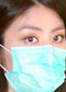

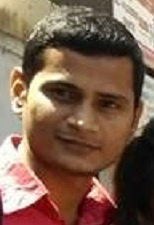

In [2]:
from PIL import Image
display(Image.open('./dataset/with_mask/0_0_0 copy 10.jpg'))
display(Image.open('./dataset/without_mask/1.jpg'))

In [3]:
# To tymczasowo, mozliwe ze nie wszystko bedzie potrzebne
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200,200)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize((200,200)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
train_data = datasets.ImageFolder('./dataset',transform=train_transform)
test_data = datasets.ImageFolder('./dataset',transform=test_transform)

In [5]:
np.random.seed(10)
class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train_idx
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [6]:
print(len(train_idx))
len(test_idx)

3094


773

In [38]:
batch_size = 10 #only to display images, trained with batch = 100
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

Class: ['with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask']


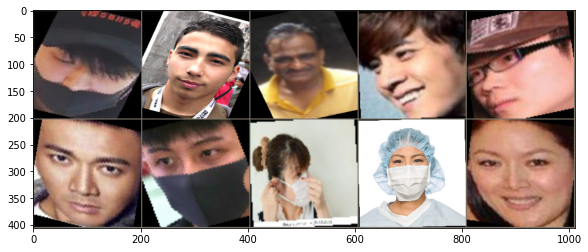

In [40]:
for images,labels in train_loader: 
    break

print('Class:', [class_names[i] for i in labels])

im = make_grid(images, nrow=5)
# denormalizacja obrazow, żeby widok był przyjemny dla oka
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
# imshow wymaga podania wymiarów w innej kolejności
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [9]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        #(((200-2)/2) - 2)/2 = 48.5; zaokrąglone w dół
        self.fc1 = nn.Linear(48*48*12, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 48*48*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [10]:
CNNmodel = ConvolutionalNetwork()

In [11]:
CNNmodel.parameters

<bound method Module.parameters of ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=27648, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)>

In [12]:
def train_model(CNNmodel, criterion, optimizer, epochs):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        for b,(X_train,y_train) in enumerate(train_loader):

            b+=1

            # predykcja
            y_pred = CNNmodel(X_train)
            # strata
            loss = criterion(y_pred, y_train)
            
            # przewidywana klasa
            predicted = torch.max(y_pred,1)[1]
            # liczba poprawnych predykcji
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # zerowanie gradientu
            optimizer.zero_grad()
            # propagacja wsteczna
            loss.backward()
            # uaktualnienie parametrów
            optimizer.step()
            
#             if b%10 == 0:
            print(f'Epoka: {i}, seria: {b}, strata: {loss}, dokładność: {trn_corr.item()/b:7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # testowanie po każdej iteracji
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):

                y_val = CNNmodel(X_test)

                predicted = torch.max(y_val,1)[1]
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

    total_time = (time.time() - start_time)/60
    
    print(f'Czas uczenia: {total_time} minut.')
    
    return CNNmodel, train_losses, test_losses, train_correct, test_correct

In [13]:
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [14]:
result = train_model(CNNmodel, criterion, optimizer, 5)

CNNmodel,train_losses, test_losses, train_correct, test_correct = result

Epoka: 0, seria: 1, strata: 0.6955021619796753, dokładność:  43.000%
Epoka: 0, seria: 2, strata: 0.6615217328071594, dokładność:  51.500%
Epoka: 0, seria: 3, strata: 1.341017723083496, dokładność:  51.333%
Epoka: 0, seria: 4, strata: 0.6407742500305176, dokładność:  53.000%
Epoka: 0, seria: 5, strata: 0.8377822637557983, dokładność:  53.200%
Epoka: 0, seria: 6, strata: 0.7046517133712769, dokładność:  52.667%
Epoka: 0, seria: 7, strata: 0.5065436363220215, dokładność:  57.429%
Epoka: 0, seria: 8, strata: 0.5018439888954163, dokładność:  60.125%
Epoka: 0, seria: 9, strata: 0.45721569657325745, dokładność:  62.556%
Epoka: 0, seria: 10, strata: 0.506167471408844, dokładność:  63.800%
Epoka: 0, seria: 11, strata: 0.35491621494293213, dokładność:  66.000%
Epoka: 0, seria: 12, strata: 0.4709494411945343, dokładność:  67.333%
Epoka: 0, seria: 13, strata: 0.2689543664455414, dokładność:  69.077%
Epoka: 0, seria: 14, strata: 0.29588809609413147, dokładność:  70.643%
Epoka: 0, seria: 15, strata:

/home/mat/.local/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoka: 0, seria: 20, strata: 0.22513137757778168, dokładność:  76.250%
Epoka: 0, seria: 21, strata: 0.3225960433483124, dokładność:  76.810%
Epoka: 0, seria: 22, strata: 0.28277453780174255, dokładność:  77.273%
Epoka: 0, seria: 23, strata: 0.3608987331390381, dokładność:  77.565%
Epoka: 0, seria: 24, strata: 0.41635045409202576, dokładność:  77.792%
Epoka: 0, seria: 25, strata: 0.2473328709602356, dokładność:  78.120%
Epoka: 0, seria: 26, strata: 0.23098433017730713, dokładność:  78.538%
Epoka: 0, seria: 27, strata: 0.20747335255146027, dokładność:  79.000%
Epoka: 0, seria: 28, strata: 0.26812389492988586, dokładność:  79.464%
Epoka: 0, seria: 29, strata: 0.41330692172050476, dokładność:  79.724%
Epoka: 0, seria: 30, strata: 0.1421024203300476, dokładność:  80.233%
Epoka: 0, seria: 31, strata: 0.3880995810031891, dokładność:  80.226%
Epoka: 1, seria: 1, strata: 0.3916684091091156, dokładność:  87.000%
Epoka: 1, seria: 2, strata: 0.28647059202194214, dokładność:  88.000%
Epoka: 1, seri

Epoka: 4, seria: 13, strata: 0.13355232775211334, dokładność:  93.231%
Epoka: 4, seria: 14, strata: 0.13184478878974915, dokładność:  93.143%
Epoka: 4, seria: 15, strata: 0.20276060700416565, dokładność:  93.000%
Epoka: 4, seria: 16, strata: 0.10539670288562775, dokładność:  93.250%
Epoka: 4, seria: 17, strata: 0.14275258779525757, dokładność:  93.412%
Epoka: 4, seria: 18, strata: 0.24406562745571136, dokładność:  93.389%
Epoka: 4, seria: 19, strata: 0.15287292003631592, dokładność:  93.316%
Epoka: 4, seria: 20, strata: 0.11802791804075241, dokładność:  93.450%
Epoka: 4, seria: 21, strata: 0.2318461835384369, dokładność:  93.333%
Epoka: 4, seria: 22, strata: 0.13447615504264832, dokładność:  93.409%
Epoka: 4, seria: 23, strata: 0.13720807433128357, dokładność:  93.435%
Epoka: 4, seria: 24, strata: 0.2025814950466156, dokładność:  93.375%
Epoka: 4, seria: 25, strata: 0.1886497437953949, dokładność:  93.400%
Epoka: 4, seria: 26, strata: 0.15195110440254211, dokładność:  93.500%
Epoka: 4,

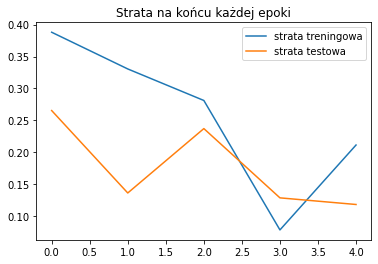

In [15]:
plt.plot(train_losses, label='strata treningowa')
plt.plot(test_losses, label='strata testowa')
plt.title('Strata na końcu każdej epoki')
plt.legend()

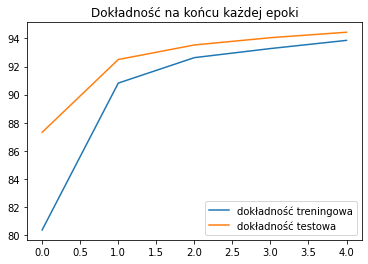

In [16]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='dokładność treningowa')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='dokładność testowa')
plt.title('Dokładność na końcu każdej epoki')
plt.legend()

In [17]:
torch.save(CNNmodel.state_dict(), 'siec_od_0_pierwsza.pt')

In [18]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('siec_od_0_pierwsza.pt'))

<All keys matched successfully>

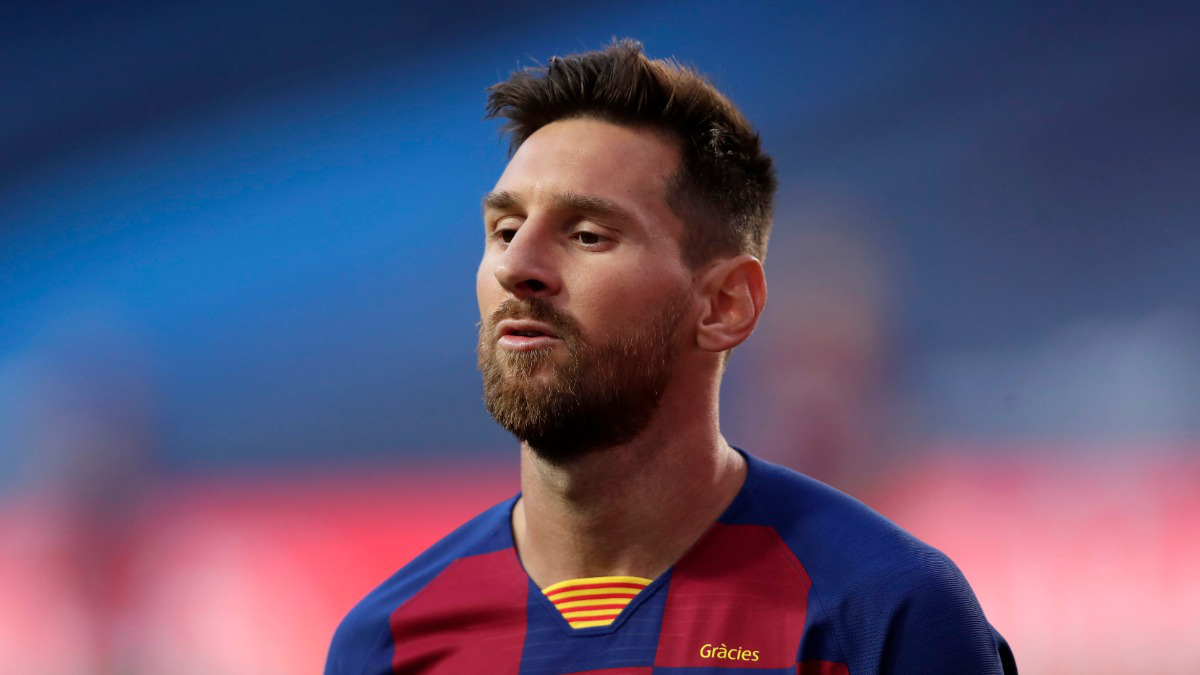

In [19]:
from PIL import Image
image = Image.open('./test_new_data/Messi_without_mask.jpg')
image

In [20]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-0.8529, -0.5554]])
tensor(1)


'without_mask'

In [33]:
class_names

['with_mask', 'without_mask']

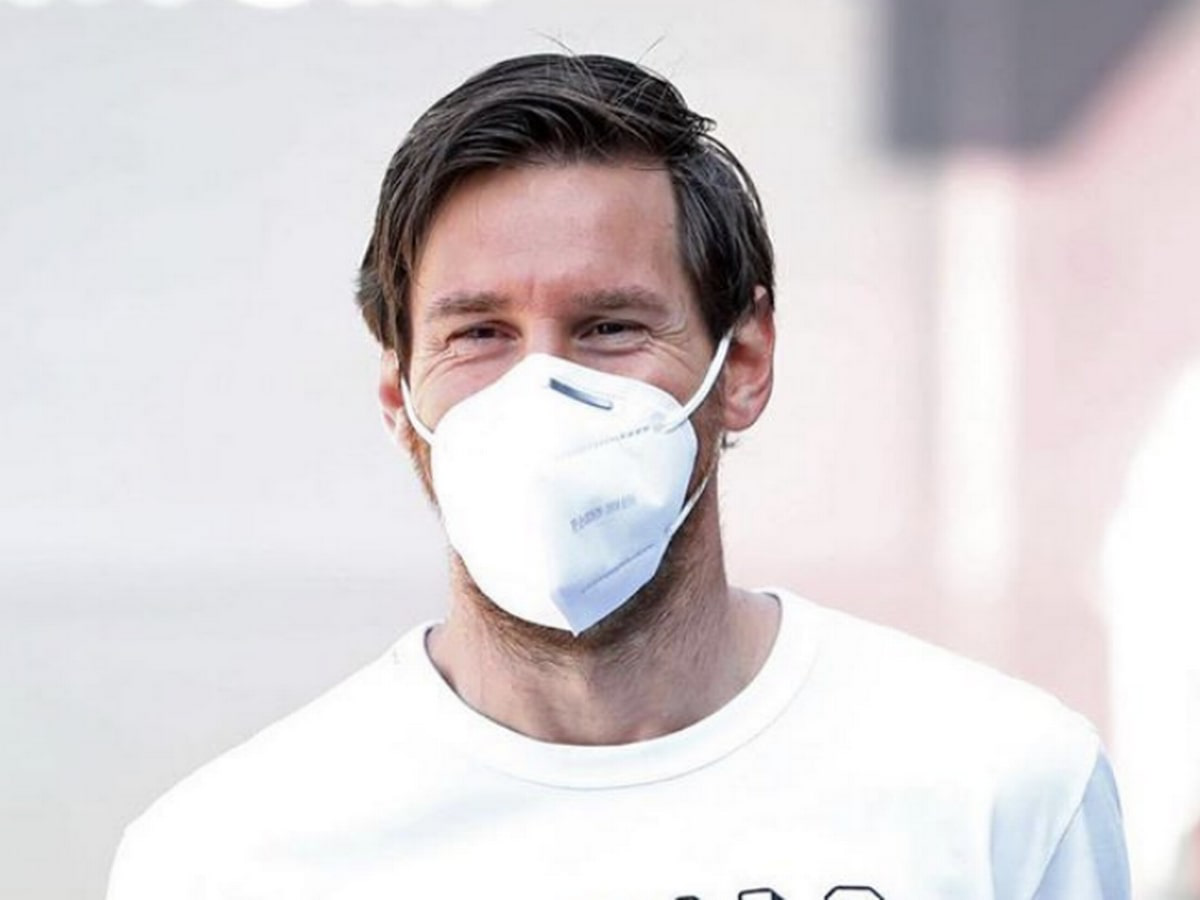

In [31]:
from PIL import Image
image = Image.open('./test_new_data/messi_mask.jpg')
image

In [32]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-2.7649e-03, -5.8921e+00]])
tensor(0)


'with_mask'

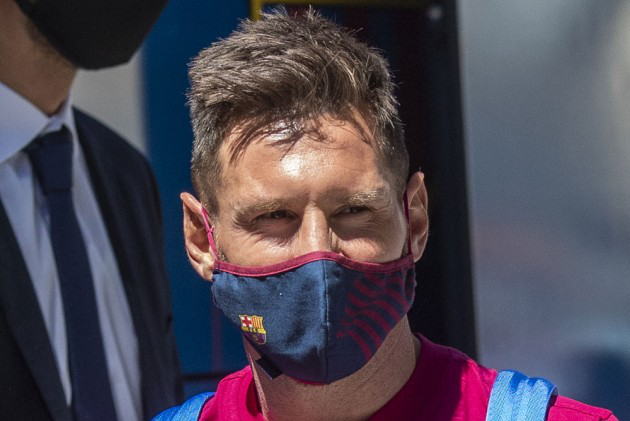

In [43]:
from PIL import Image
image = Image.open('./test_new_data/Messi_with_mask.jpg')
image

In [44]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-1.2103, -0.3540]])
tensor(1)


'without_mask'